In [1]:
import itertools
from datetime import datetime

import pandas as pd
from pandas import DataFrame

import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pandas.io.data import DataReader

# visualization in IPython Notebook
%matplotlib inline

# helper function that downloads S&P 500 company names, symbols and industry sectors
from sp500_downloader import stock_saver

In [2]:
try:
    company_symbols = pd.read_csv("sp500.csv")

except IOError:
    source = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    stock_saver(source, "sp500.csv")
    
    company_symbols = pd.read_csv("sp500.csv")

# focuse analysis on IT companies
tech_symbols = company_symbols.loc[company_symbols["GICS Sector"]=="Information Technology"]

symbols = tech_symbols["Ticker symbol"].values
names = tech_symbols["Security"].values

In [3]:
stock_data = {}

# get data from last two years
end = datetime.now()
start = datetime(end.year-2, end.month, end.day)

for name, symbol in itertools.izip(names, symbols):
    try:
        dframe = DataReader(symbol, "yahoo", start, end)
        
    except IOError:
        print "The information for {0} is not available".format(name)
        
    else:
        # data cleanup
        for item in ["High", "Low"]:
            dframe[item] = dframe[item] * dframe["Adj Close"] / dframe["Close"]
        
        dframe.drop(["Open", "Close"], axis=1, inplace=True)
        dframe.rename(columns={"Adj Close":"Close"}, inplace=True)
        
        # add a column for the difference between high and low prices
        dframe["Diff"] = dframe["High"] - dframe["Low"]
        
        stock_data[name] = dframe

In [4]:
# get to know the data
apple_data = stock_data["Apple Inc."]
apple_data.describe()

,High,Low,Volume,Close,Diff
count,503.000000,503.000000,5.030000e+02,503.000000,503.000000
mean,95.939498,94.327766,6.500961e+07,95.131127,1.611733
std,22.505202,22.096792,3.110176e+07,22.293180,0.917538
min,58.524440,57.393583,1.447960e+07,57.431964,0.449555
25%,74.489516,73.581823,4.476885e+07,74.139780,1.004827
50%,94.334622,93.076697,5.805240e+07,93.577904,1.344483
75%,116.476863,114.269830,7.665700e+07,114.775710,1.927951
max,133.980348,131.399994,2.663808e+08,132.539993,7.915569


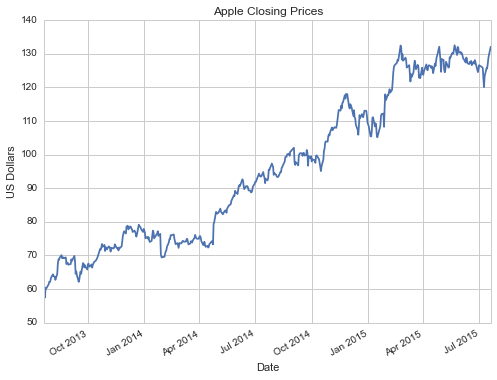

In [5]:
apple_data["Close"].plot(title="Apple Closing Prices", figsize=(8, 6)) 
plt.ylabel("US Dollars")

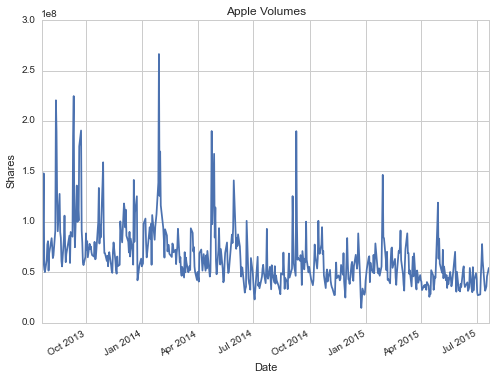

In [6]:
apple_data["Volume"].plot(title="Apple Volumes", figsize=(8, 6))
plt.ylabel("Shares")

In [7]:
# calculate moving averages
ma_lengths = [20, 50, 100, 200]

for dframe in stock_data.values():
    for length in ma_lengths:
        column = "MA_" + str(length)
        dframe[column] = pd.rolling_mean(dframe["Close"], length)

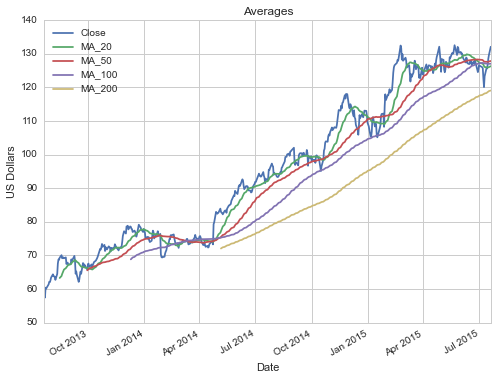

In [8]:
# plot moving averages
apple_data[["Close", "MA_20", "MA_50", "MA_100", "MA_200"]].plot(title="Averages", figsize=(8, 6))
plt.ylabel("US Dollars")

In [9]:
# calculate daily returns
for dframe in stock_data.values():
    dframe["Daily Return"] = dframe["Close"].pct_change()

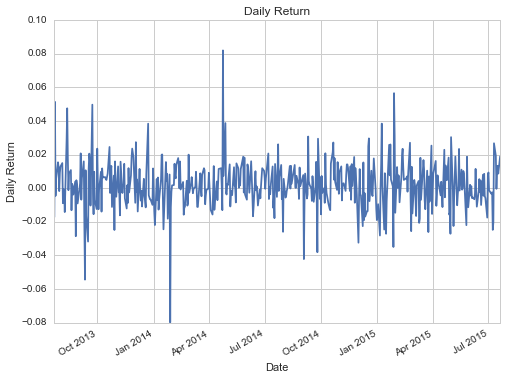

In [10]:
# plot daily returns
apple_data["Daily Return"].plot(title="Daily Return", figsize=(8, 6))
plt.ylabel("Daily Return")

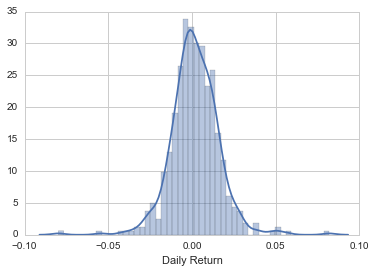

In [11]:
# another way to visualize the daily returns data
sns.distplot(apple_data["Daily Return"].dropna(), bins=50)

In [12]:
# review the information we get so far
apple_data.describe()

,High,Low,Volume,Close,Diff,MA_20,MA_50,MA_100,MA_200,Daily Return
count,503.000000,503.000000,5.030000e+02,503.000000,503.000000,484.000000,454.000000,404.000000,304.000000,502.000000
mean,95.939498,94.327766,6.500961e+07,95.131127,1.611733,95.177749,95.049366,94.697331,93.950946,0.001728
std,22.505202,22.096792,3.110176e+07,22.293180,0.917538,21.648871,20.702905,18.808733,14.415072,0.014357
min,58.524440,57.393583,1.447960e+07,57.431964,0.449555,63.267336,65.541768,68.809224,72.043458,-0.079927
25%,74.489516,73.581823,4.476885e+07,74.139780,1.004827,74.281333,74.966321,75.313617,81.251967,-0.006349
50%,94.334622,93.076697,5.805240e+07,93.577904,1.344483,94.233182,93.767621,93.591322,92.467581,0.001184
75%,116.476863,114.269830,7.665700e+07,114.775710,1.927951,113.100597,111.815954,110.852881,107.068566,0.010189
max,133.980348,131.399994,2.663808e+08,132.539993,7.915569,129.850499,128.293787,127.263971,119.057268,0.081982


In [13]:
# build features for each stock
columns = ["High Avg", "High SD", "Low Avg", "Low SD", "Diff Avg", "Diff SD",
           "Volume Avg", "Volume SD", "Close Avg", "Close SD", 
           "MA_20 Avg", "MA_20 SD", "MA_50 Avg", "MA_50 SD",
           "MA_100 Avg", "MA_100 SD", "MA_200 Avg", "MA_200 SD",
           "Daily Return Avg", "Daily Return SD", "2 Year Return"]

index = sorted(stock_data.keys(), key=lambda name: name.lower())

training_df = DataFrame(index=index, columns=columns)

# add data to the dataframe
for company in stock_data.keys():
    df = stock_data[company]
    
    two_year_return = (df["Close"].iloc[-1] - df["Close"].iloc[0]) / df["Close"].iloc[0]
    
    training_df.loc[company] = [df["High"].mean(), df["High"].std(),
                                df["Low"].mean(), df["Low"].std(),
                                df["Diff"].mean(), df["Diff"].std(),
                                df["Volume"].mean(), df["Volume"].std(),
                                df["Close"].mean(), df["Close"].std(),
                                df["MA_20"].mean(), df["MA_20"].std(),
                                df["MA_50"].mean(), df["MA_50"].std(),
                                df["MA_100"].mean(), df["MA_100"].std(),
                                df["MA_200"].mean(), df["MA_200"].std(),
                                df["Daily Return"].mean(), df["Daily Return"].std(),
                                two_year_return]

training_df = training_df.astype(float)

In [14]:
# feature scaling by mean normalization
for column in columns:
    training_df[column] = (training_df[column] - training_df[column].mean()) \
                            / (training_df[column].max() - training_df[column].min())

In [15]:
# a quick look at the resulting dataframe
training_df.head()

,High Avg,High SD,Low Avg,Low SD,Diff Avg,Diff SD,Volume Avg,Volume SD,Close Avg,Close SD,...,MA_20 SD,MA_50 Avg,MA_50 SD,MA_100 Avg,MA_100 SD,MA_200 Avg,MA_200 SD,Daily Return Avg,Daily Return SD,2 Year Return
Accenture plc,0.014911,-0.019805,0.015618,-0.019173,-0.026789,-0.040549,-0.087685,-0.118582,0.015284,-0.019124,...,-0.023282,0.013377,-0.024448,0.012627,-0.034019,0.011528,-0.041628,-0.020326,-0.220292,-0.024709
Adobe Systems Inc,-0.012441,0.012942,-0.012323,0.013242,-0.019446,-0.024772,-0.081724,-0.100559,-0.012347,0.013004,...,0.010975,-0.013175,0.007206,-0.012749,0.008795,-0.012203,0.016192,0.019440,-0.007785,0.053174
Akamai Technologies Inc,-0.026462,0.000161,-0.026584,0.002294,-0.019227,-0.025378,-0.101859,-0.119351,-0.026497,0.001320,...,0.002785,-0.027950,0.006499,-0.028677,0.011248,-0.028633,0.007649,0.019343,0.095448,0.044009
Alliance Data Systems,0.355760,0.446981,0.354508,0.450929,0.429693,0.417573,-0.121862,-0.144615,0.355172,0.446727,...,0.443838,0.356216,0.428710,0.355451,0.445433,0.351367,0.366549,0.007437,-0.053850,0.027119
Altera Corp,-0.069197,-0.085663,-0.069049,-0.085425,-0.077983,-0.015831,-0.071334,-0.019664,-0.069110,-0.085466,...,-0.093654,-0.071694,-0.111511,-0.072558,-0.159501,-0.072517,-0.150693,-0.003237,0.157061,-0.012483


In [16]:
# check the data in training dataframe
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, Accenture plc to Yahoo Inc.
Data columns (total 21 columns):
High Avg            67 non-null float64
High SD             67 non-null float64
Low Avg             67 non-null float64
Low SD              67 non-null float64
Diff Avg            67 non-null float64
Diff SD             67 non-null float64
Volume Avg          67 non-null float64
Volume SD           67 non-null float64
Close Avg           67 non-null float64
Close SD            67 non-null float64
MA_20 Avg           66 non-null float64
MA_20 SD            66 non-null float64
MA_50 Avg           66 non-null float64
MA_50 SD            66 non-null float64
MA_100 Avg          66 non-null float64
MA_100 SD           66 non-null float64
MA_200 Avg          65 non-null float64
MA_200 SD           65 non-null float64
Daily Return Avg    67 non-null float64
Daily Return SD     67 non-null float64
2 Year Return       67 non-null float64
dtypes: float64(21)
memory usage: 11.5+ KB

In [17]:
# notice that some moving averages infomation is missing
# fill in the missing values with the median in that column
for column in ["MA_20 Avg", "MA_20 SD",
               "MA_50 Avg", "MA_50 SD",
               "MA_100 Avg", "MA_100 SD",
               "MA_200 Avg", "MA_200 SD",]:
    training_df.loc[training_df[column].isnull(), column] =\
        training_df[column].median()

In [18]:
# now check the dataframe does not contain any null values again
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, Accenture plc to Yahoo Inc.
Data columns (total 21 columns):
High Avg            67 non-null float64
High SD             67 non-null float64
Low Avg             67 non-null float64
Low SD              67 non-null float64
Diff Avg            67 non-null float64
Diff SD             67 non-null float64
Volume Avg          67 non-null float64
Volume SD           67 non-null float64
Close Avg           67 non-null float64
Close SD            67 non-null float64
MA_20 Avg           67 non-null float64
MA_20 SD            67 non-null float64
MA_50 Avg           67 non-null float64
MA_50 SD            67 non-null float64
MA_100 Avg          67 non-null float64
MA_100 SD           67 non-null float64
MA_200 Avg          67 non-null float64
MA_200 SD           67 non-null float64
Daily Return Avg    67 non-null float64
Daily Return SD     67 non-null float64
2 Year Return       67 non-null float64
dtypes: float64(21)
memory usage: 11.5+ KB

In [19]:
# convert training data frame to numpy array before machine learning
training_data = training_df.values

training_data.shape

(67, 21)

In [20]:
# use PCA for dimension reduction so we can see the stocks in a 2D plot
pca = PCA(n_components=2)
pca.fit(training_data)
training_data_reduced = pca.transform(training_data)

training_data_reduced.shape

(67, 2)

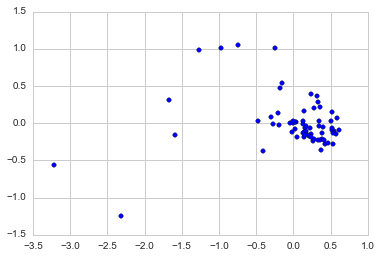

In [21]:
# plot results
plt.scatter(training_data_reduced[:, 0], training_data_reduced[:, 1])

####As we can see, the majority of the S&P 500 IT comany stocks seem to have similar performances.

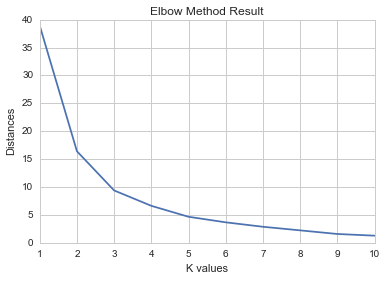

In [22]:
# next we cluster the stocks by K-means algorithm
# chose k value by "elbow method"
distances = np.zeros(10)
k_values = np.arange(1, 11)

for k in k_values:
    cluster = KMeans(k)
    cluster.fit(training_data_reduced)
    distances[k-1] = cluster.inertia_

plt.plot(k_values, distances)
plt.title("Elbow Method Result")
plt.xlabel("K values")
plt.ylabel("Distances")

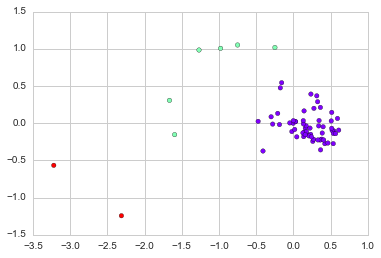

In [23]:
# as we can see, the elbow is at k = 3
best_cluster = KMeans(3)
best_cluster.fit(training_data_reduced)
y = best_cluster.predict(training_data_reduced)

plt.scatter(training_data_reduced[:, 0], training_data_reduced[:, 1], c=y, cmap="rainbow")

<h3><font color="blue">Thus, most IT company stocks in the S&P 500 list cluster together according to the features we selected. Next, it would be interesting to investigate how these three stock clusters perform differently in terms of trading volumes, moving averages, returns and so on.</font></h3>